In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import tensorflow as tf

In [2]:
from random import shuffle

def createMachineDigitsDataset(img_shape):
    fonts = [cv2.FONT_HERSHEY_SIMPLEX,
            cv2.FONT_HERSHEY_PLAIN,
            cv2.FONT_HERSHEY_DUPLEX,
            cv2.FONT_HERSHEY_COMPLEX,
            cv2.FONT_HERSHEY_TRIPLEX,
            cv2.FONT_HERSHEY_COMPLEX_SMALL,
            cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,
            cv2.FONT_HERSHEY_SCRIPT_COMPLEX]
    font_sizes = [1, 1.2, 1.4, 1.6, 1.75]
    thickness = [1, 2]
    dataset = []
    for f in fonts:
        for s in font_sizes:
            for t in thickness:
                for i in range(10):
                    for x in [4, 3, -3,  2, -2, -4, 1, -1, 0]:
                        for y in [4, 3, -3, 2, -2, -4, 1, -1, 0]:
                            if s is 1.75 and y is 4:
                                y = 3
                            img = np.zeros(list(img_shape), dtype=np.float32)
                            img[:, :] = 1
                            text_size = cv2.getTextSize(str(i), f, s, t)[0]
                            textX = (img.shape[1] - text_size[0]) // 2
                            textY = (img.shape[0] + text_size[1]) // 2
                            img = cv2.putText(img, str(i), (textX + x, textY + y), f, s, [0], t, cv2.LINE_AA)
                            dataset.append((img, i))
    shuffle(dataset)
    images, labels = zip(*dataset)
    training = (np.array(images[0:55000], dtype=np.float32), np.array(labels[0:55000], dtype=np.int32))
    test = (np.array(images[55000:], dtype=np.float32), np.array(labels[55000:], dtype=np.int32))
    return training, test

In [ ]:
train, test = createMachineDigitsDataset((42, 42))
print(train[0].shape)
print(test[0].shape)

In [ ]:
np.savez_compressed('machine_digits_dataset', training_input = train[0], training_output = train[1], 
        test_input = test[0], test_output = test[1])

In [3]:
def convert_one_hot(feature, label):
    return (feature, tf.one_hot(label, 10, on_value=1.0, off_value=0.0, dtype=tf.float32, axis=-1))

with np.load('machine_digits_dataset.npz') as data:
    train = (data["training_input"], data["training_output"])
    test = (data["test_input"], data["test_output"])

training_dataset = tf.contrib.data.Dataset.from_tensor_slices(train)
training_dataset = training_dataset.map(convert_one_hot)
training_dataset = training_dataset.repeat()
training_dataset = training_dataset.batch(50)


test_dataset = tf.contrib.data.Dataset.from_tensor_slices(test)
test_dataset = test_dataset.map(convert_one_hot) 
test_dataset = test_dataset.batch(50)

In [4]:
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, name = "x")
    x_image = tf.reshape(x, [-1, 42, 42, 1])
    y = tf.placeholder(tf.float32, name = "y")

In [5]:
with tf.name_scope('conv1'):
    w1 = tf.Variable(tf.truncated_normal([5, 5, 1, 32], stddev = 0.1), name="w1")
    b1 = tf.Variable(tf.truncated_normal([32], stddev = 0.1), name="b1")
    conv1 = tf.nn.relu(tf.add(tf.nn.conv2d(x_image, w1, strides = [1, 1, 1, 1], padding='SAME'), b1))
    
    
with tf.name_scope('pool1'):
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [6]:
with tf.name_scope('conv2'):
    w2 = tf.Variable(tf.truncated_normal([5, 5, 32, 64], stddev = 0.1), name="w2")
    b2 = tf.Variable(tf.truncated_normal([64], stddev = 0.1), name="b2")
    conv2 = tf.nn.relu(tf.add(tf.nn.conv2d(pool1, w2, strides = [1, 1, 1, 1], padding = 'SAME'), b2))
    
    
with tf.name_scope('pool2'):
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [7]:
with tf.name_scope('fc1'):
    w_fc1 = tf.Variable(tf.truncated_normal([11*11*64, 1536], stddev = 0.1), name="w_fc1")
    b_fc1 = tf.Variable(tf.truncated_normal([1536], stddev = 0.1), name = "b_fc1")
    
    pool2_flat = tf.reshape(pool2, [-1, 11*11*64])
    fc1 = tf.nn.relu(tf.add(tf.matmul(pool2_flat, w_fc1), b_fc1))

    keep_prob = tf.placeholder(tf.float32, name = "keep_prob")
    fc1_drop = tf.nn.dropout(fc1, keep_prob)

In [8]:
with tf.name_scope('fc2'):
    w_fc2 = tf.Variable(tf.truncated_normal([1536, 10], stddev = 0.1), name="w_fc2")
    b_fc2 = tf.Variable(tf.truncated_normal([10], stddev = 0.1), name="b_fc2")

    y_ = tf.add(tf.matmul(fc1_drop, w_fc2), b_fc2)

In [9]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = y_, name = "cross_entropy"))
training_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
num_correct = tf.reduce_sum(tf.cast(tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1)), tf.float32))

0


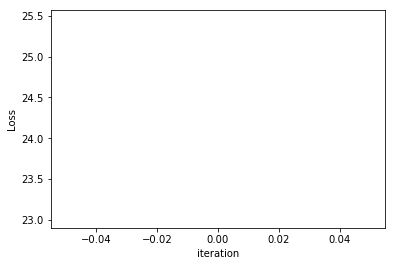

In [ ]:
num_iter = 1
loss = []
test_size = 9800

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    iterator = training_dataset.make_one_shot_iterator()
    next_element = iterator.get_next()
    for i in range(num_iter):
        if i % 100 is 0:
            print(i)
        try:
            batch = sess.run(next_element)
            _, training_loss = sess.run([training_step, cross_entropy], feed_dict = {x : batch[0], y : batch[1], keep_prob : 0.5})
            loss.append(training_loss)
        except tf.errors.OutOfRangeError:
            break
        
    plt.plot(list(range(num_iter)), loss)
    plt.xlabel('iteration')
    plt.ylabel('Loss')
    plt.show()
    
    iterator = test_dataset.make_one_shot_iterator()
    next_element = iterator.get_next()
    total_correct = 0
    while True:
        try:
            batch = sess.run(next_element)
            total_correct = total_correct + sess.run(num_correct, feed_dict = {x : batch[0], y : batch[1], keep_prob : 1.0})
        except tf.errors.OutOfRangeError:
            break
    print(total_correct / test_size)
    save_path = saver.save(sess, "F:\\Code\\Python\\machine_digits_model\\machine_digits_classifier.ckpt")
    print("Model saved in file: %s" % save_path)